---
title: STATS 3DA3
subtitle: Homework Assignment 6
author: "Ruziyi Duan (400292089), Xiangyi Li (400297427), Jinglong Yu (400334351)"
date: 16/04/2024
format: pdf
header-includes:
   - \usepackage{amsmath}
   - \usepackage{bbm}
   - \usepackage{array}
   - \usepackage{multirow}
   - \usepackage{graphicx}
   - \usepackage{float}
   - \usepackage{apacite}
   - \usepackage{natbib}
execute: 
  echo: true
fontsize: 11pt
bibliography: ref_proj.bib
geometry: margin = 1in
linestretch: 1.5
---

\newpage

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import neighbors

1. **Classification Problem Identification:**
This dataset collects indicators from patients in the hospital over a two-month period, which can be used to analyze the physical condition of different patients according to the model and to analyze and predict what physical indicators are most useful for obtaining ckd, using the presence or absence of ckd as the goal.

Data overview

In [489]:
ckd = pd.read_csv("kidney_disease.csv") # save csv in dataset ckd
print(ckd.head(5))
print(ckd.dtypes)
print(ckd.shape[0])

   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]
id                  int64
age               float64
bp                

The kidney has both numerical and object variables. There are 26 variables and 400 observations. Some of the variables such as rbc, bc etc are binary object. It is easy to oberve that the dataset exist missing value. So for the further analysis we will transform the variables and handling missing value.

Missing Value Analysis and Handling

In [490]:
ckd = pd.read_csv("kidney_disease.csv")
print(ckd.isna().sum()) # check uniqueness


id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64


In [491]:
ckd = ckd.drop(columns=['rbc']) # drop rbc
ckd = ckd.drop(columns=['rc'])
ckd = ckd.dropna(axis = 0)
print(ckd.isna().sum()) #check

id                0
age               0
bp                0
sg                0
al                0
su                0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64


Since the dataset have huge amount missing value, therefre we can't drop all of them. Instead.we drop all the variables who has more than 100 missing value. Since "rbc"" are binary variable. We can't replace the Na with mean. For rc are string and contain a lot missing value. So we drop t

Variable Transformation: categorical transform and standarlize

In [492]:
float_col=ckd.select_dtypes(include=["float64"]).columns
scalar=StandardScaler()
ckd[float_col]=scalar.fit_transform(ckd[float_col])

In [493]:

cat = ['pc','pcc',"ba","htn","dm","cad","appet","pe","ane"]
for col in cat:
    ckd[col] = pd.Categorical(ckd[col]).codes # categorical



Data overview(after transformed)

In [494]:
ckd.describe()

,id,age,bp,sg,al,su,pc,pcc,ba,bgr,...,sc,sod,pot,hemo,htn,dm,cad,appet,pe,ane
count,193.000000,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,193.00000,193.000000,193.000000,1.930000e+02,...,1.930000e+02,1.930000e+02,1.930000e+02,1.930000e+02,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,246.046632,-1.840784e-17,-2.945255e-16,1.840784e-15,-3.681569e-17,7.363137e-17,0.80829,0.103627,0.067358,-1.472627e-16,...,-3.681569e-17,-1.398996e-15,-9.203921e-17,-3.681569e-16,0.295337,0.253886,0.082902,0.145078,0.139896,0.113990
std,115.697895,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,0.39467,0.305569,0.251292,1.002601e+00,...,1.002601e+00,1.002601e+00,1.002601e+00,1.002601e+00,0.457380,0.436365,0.276450,0.353095,0.347782,0.318625
min,3.000000,-2.824355e+00,-2.167392e+00,-2.467630e+00,-6.182036e-01,-3.576832e-01,0.00000,0.000000,0.000000,-1.541183e+00,...,-6.432564e-01,-3.983240e+00,-6.627243e-01,-3.589541e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,159.000000,-6.291510e-01,-4.316798e-01,-6.971744e-01,-6.182036e-01,-3.576832e-01,1.00000,0.000000,0.000000,-5.624299e-01,...,-5.079078e-01,-5.261727e-01,-2.501250e-01,-7.298716e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,269.000000,1.862105e-01,4.361765e-01,1.880536e-01,-6.182036e-01,-3.576832e-01,1.00000,0.000000,0.000000,-2.846757e-01,...,-3.725592e-01,5.000507e-02,-5.969452e-02,1.880471e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,344.000000,7.506915e-01,4.361765e-01,1.073282e+00,8.368366e-01,-3.576832e-01,1.00000,0.000000,0.000000,-5.982713e-02,...,-3.506440e-04,6.261829e-01,9.899752e-02,7.529201e-01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,399.000000,2.444135e+00,3.039745e+00,1.073282e+00,2.291877e+00,4.952536e+00,1.00000,1.000000,1.000000,4.648767e+00,...,4.364641e+00,1.634494e+00,1.346087e+01,1.600230e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We observe that the std for the categorical variables are very low since it is neither 1 or 0 so the variability are very low. The other numeric variabels such as "sc" has relative high std which means they have higher variability. And we can see after drop the missing value. We have 158 availbe obervations

show the Association Between Variables
id has no relate to any other variables

<Axes: >

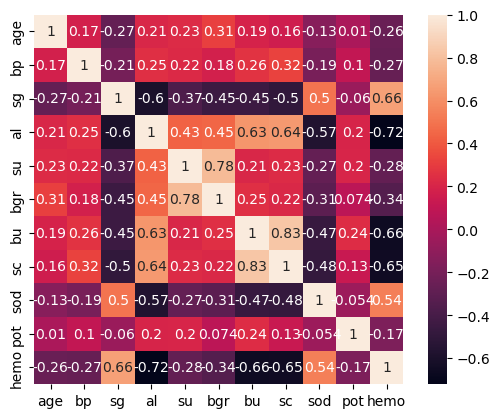

In [495]:
corr=ckd[float_col].corr()
sns.heatmap(corr,annot=True,cbar=True,square=True)

`bu` and `sc` have a quite high positive correlation which means sugar and the level of blood glucose random have a strong relationship. When sc increases, the level of bu also tends to increase.

`al`, `bu`, and `sc` are highly negative correlated with `hemo` which means when albumin, blood urea, and serum creatinine have strong relationship with the level of hemoglobin. When they increase, the level of hemoglobin tends to decrease.

Secondly, 'Bgr' and 'su' also highly positivitycorrelated since they have the correlation 0.78. Which means blood glucose random and serum creatinine are highly positivly correlated.

Outlier anaylsis

In [496]:
z_scores = ckd.select_dtypes(include='number').apply(zscore)
outliers = (z_scores > 3) | (z_scores < -3)
print(outliers.sum())

id        0
age       0
bp        1
sg        0
al        0
su        5
pc        0
pcc       0
ba       13
bgr       5
bu        4
sc        9
sod       4
pot       1
hemo      1
htn       0
dm        0
cad      16
appet     0
pe        0
ane       0
dtype: int64


 Decision trees are robust to outliers in general, as decision trees can adapt to them by choosing appropriate split points.

Sub group anaylsis

Fit a classification tree to predict `classification` using all variables except `id` since it has no correlation with the classification of CKD.

In [497]:
X = ckd.drop(['id', 'classification'], axis=1)
y = ckd.classification

Data Splitting 30%/70%

In [498]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

Classifier Choices: Decision tree and KNN

In [499]:
ckd_cld = DecisionTreeClassifier(
    max_depth = 10, 
    random_state=0
) 

In [500]:
ckd_cld.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

<function matplotlib.pyplot.show(close=None, block=None)>

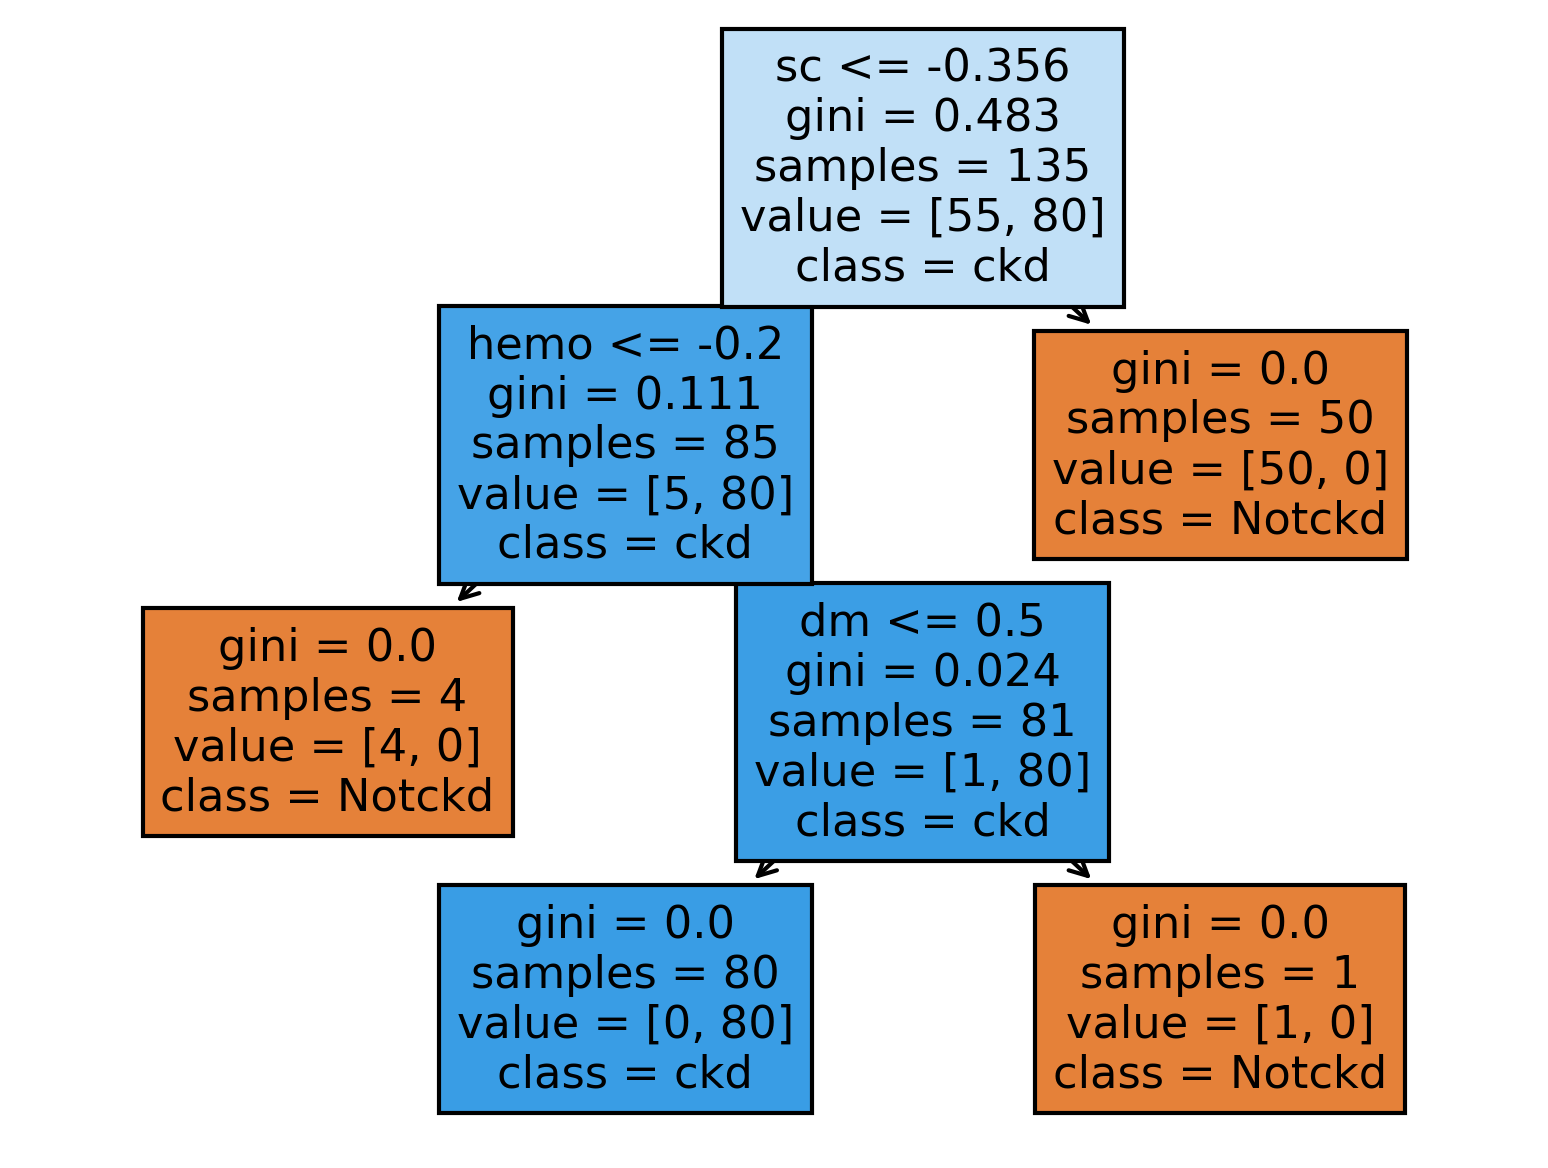

In [501]:
fig, axes = plt.subplots(
    nrows = 1,ncols = 1, dpi=300
    )
plot_tree(
    ckd_cld,
    max_depth= 4, 
    feature_names = X_train.columns.tolist(), 
    class_names=['Notckd', 'ckd'], 
    filled = True
    )
plt.show

In [502]:
pred =  ckd_cld.predict(X_test)

In [503]:
ckd_cld.score(X_test, y_test)

1.0

In [504]:
cm = pd.DataFrame(confusion_matrix(y_test, pred), index=['notckd', 'ckd'], columns=['notckd', 'ckd'])
cm.index.name = 'True'
cm.columns.name = 'Predicted'
print(cm)

Predicted  notckd  ckd
True                  
notckd         23    0
ckd             0   35


The decsion tree test has 100% accurency. It might cause by lack of the dataset and overfiting.The dataset may be small or highly homogeneous, making it easier for the model to achieve perfect accuracy.

Accoring the martrix. We can say all the ckd group has been recgnize as ckd and all notckd has been recognize as notckd. The model are has high accurecy on predict clasification

In [505]:
X_test = X_test.to_numpy()

In [518]:
k_range = range(1, 15)
scores = []
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(round(metrics.accuracy_score(y_test, y_pred),2))
print(scores)


c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWa

[0.88, 0.72, 0.71, 0.71, 0.74, 0.76, 0.72, 0.78, 0.74, 0.78, 0.72, 0.74, 0.71, 0.72]


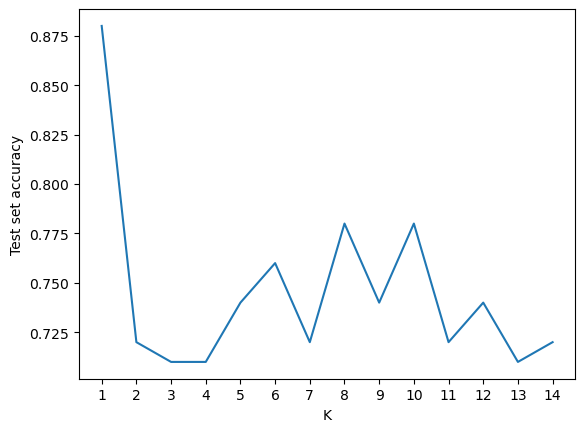

In [507]:
plt.plot(k_range, scores)
plt.xlabel('K')
plt.ylabel('Test set accuracy')
plt.xticks(range(1,15))
plt.show()


Accroding to the plot. We observe that k=8 has the best performance(0.78). Althogh k=1 also has same test score, how ever, the k=1 is too low which might cause overfitting. If k is too large. it is also not best k fit model. When k=6 it has a relavent high acuracny. So I would choose that point

In [511]:
knn8 = neighbors.KNeighborsClassifier(n_neighbors=8)
knn8.fit(X_train, y_train)
pred8 = knn8.predict(X_test)
print(metrics.confusion_matrix(y_test, pred8).T)

[[15  5]
 [ 8 30]]


c:\Users\yjl34\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Compare model

In [517]:
from sklearn.metrics import adjusted_rand_score
ari2 = adjusted_rand_score(y_test, pred8) # For knn
ari1 = adjusted_rand_score(y_test, pred) # For decsion tree
print(ari1,ari2)

1.0 0.2907114486795345


Comparing two classification methods by ARI value, the method with a higher ARI value indicates that it is suitable for the dataset to predict the category. Therefore, we say decision tree is a better classifier for the CKD dataset.

Feature importance

In [520]:
fea_imp = ckd_cld.feature_importances_
sorted_indices = fea_imp.argsort()[::-1]# read from the tail of the argsort to get greatest to least indices of the elements
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = fea_imp[sorted_indices]

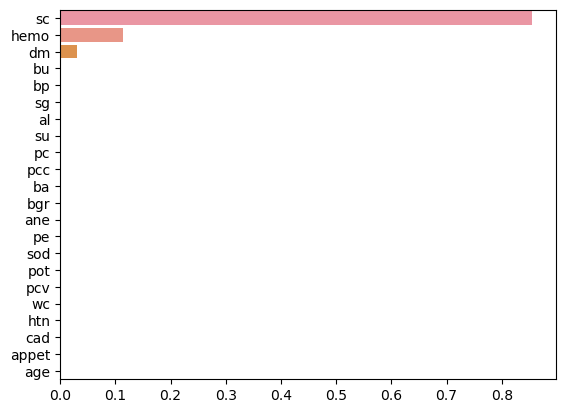

In [521]:
sns.barplot(x = sorted_importances, y = sorted_feature_names)
plt.show()

When I visulize the decsion tree model and It is easy to observe the varable 'sc' hsa significant effect to the predict variable classification. Serum creatinine significantly influences the likelihood of chronic kidney disease, with elevated levels potentially indicating compromised kidney function.

The sg and al are the other two variables has strong effec to the predict variabe. As the plot showed. These two variabes don't have siginicant importance as sc did. However, they still have strong effect compare to other variabels in the model.

Improvement for futher analysis

The accuracy of decision tree is 100% which indicates that the model is overfitting. This may be caused by the small amount of the dataset since we drop all the missing values. We can replace the missing values in each numerical variable by their median, and this may be can improve the situation of overfitting.

Team Contributions:

Jinglong YU(400334351,git id Babycarrot2001) make decsion tree model and transformed the data. Improve the knn model function. Analysis feature importance.

Ruziyi Duan:Refernce, classifier choice, interpret insight, performnce

Xiangyi Li: problem identification, association description, KNN classification

Link to git
https://github.com/Babycarrot2001/3da.git